## Definitions

In [193]:
train_path = '../results/bertopic/bertopic_processed_data_2022-11-22_23-14-24_train.csv'
test_path = '../results/bertopic/bertopic_processed_data_2022-11-22_23-14-24_test.csv'

results_folder = '../results/bertopic_nbco/'

# train_path = '../results/bertopic/bertopic_raw_data_2022-11-22_23-51-25_train.csv'
# test_path = '../results/bertopic/bertopic_raw_data_2022-11-22_23-51-25_test.csv'

In [152]:
UMLS_ST21pv_ontologies_ids = ['CPT', 'FMA', 'GO', 'HGNC', 'HPO', 'ICD10', 'ICD10CM', 'ICD9CM', 'MDR', 'MSH', 'MTH', 'NCBI', 'NCI', 'NDDF', 'NDFRT', 'OMIM', 'RXNORM', 'SNOMEDCT_US']

# HPO = HP
# MDR = MEDDRA
# MSH = MESH
# MTH = ?
# NCBI = NCBITAXON
# NCI = NCIT
# SNOMEDCT_US = SNMI
UMLS_NCBO_ST21pv_ontologies_ids = ['CPT', 'FMA', 'GO', 'HGNC', 'HP', 'ICD10', 'ICD10CM', 'ICD9CM', 'MEDDRA', 'MESH', 'NCBITAXON', 'NCIT', 'NDDF', 'NDFRT', 'OMIM', 'RXNORM', 'SNMI']


UMLS_ST21pv_semantic_types_ids = ['T005', 'T007', 'T017', 'T022', 'T031', 'T033', 'T037', 'T038',
'T058', 'T062', 'T074', 'T082', 'T091', 'T092', 'T097', 'T098', 'T103', 'T168', 'T170', 'T201', 'T204']

## Read the data to annotate

In [153]:
def transform_strings_to_arrays(df, col_names = ['tokenized_sentences', 'tokenized_words', 'tokenized_words_processed']):
    for col in col_names:
        df[col] = df[col].apply(eval)
    return df

In [171]:
import datetime
def get_now_str():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [160]:
import pandas as pd
import re

def read_berttopic_results(path):
    data = pd.read_csv(path, index_col=0)
    data = transform_strings_to_arrays(data, col_names = ['topic_keywords'])
    data['text_to_annotate'] = data.topic_keywords.apply(
        lambda row: re.sub(r"[\'\[\]]", "", str([keyword[0] for keyword in row]))
        )
        
    return data

In [161]:
train_data = read_berttopic_results(train_path)
test_data = read_berttopic_results(test_path)

In [157]:
train_data

,PMID,topic_number,topic_probs,topic_keywords
0,25763772,52,1.000000,"pneumonia, antimicrobi, isol, hmkp, infect, nt..."
1,25847295,57,1.000000,"zinc, cell, apoptosi, nonylphenol, naf, induc,..."
2,26316050,2,1.000000,"nanoparticl, surfac, coat, properti, np, relea..."
3,26406200,4,1.000000,"fractur, knee, bone, spine, implant, patient, ..."
4,26424709,-1,0.000000,"patient, studi, effect, associ, differ, group,..."
...,...,...,...,...
3508,28549399,-1,0.000000,"patient, studi, effect, associ, differ, group,..."
3509,28549760,24,0.909189,"obes, food, weight, children, overweight, heal..."
3510,28550154,2,1.000000,"nanoparticl, surfac, coat, properti, np, relea..."
3511,28550348,-1,0.000000,"patient, studi, effect, associ, differ, group,..."


## NCBO tagger API connection

In [126]:
import urllib.request, urllib.error, urllib.parse
import json
import os
from pprint import pprint

REST_URL = "http://data.bioontology.org"
API_KEY = "194c9635-ce67-4e70-81c5-898c3a2b30fb"

def get_json(url):
    opener = urllib.request.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    return json.loads(opener.open(url).read())

def print_annotations(annotations, get_class=True):
    for result in annotations:
        class_details = result["annotatedClass"]
        if get_class:
            try:
                class_details = get_json(result["annotatedClass"]["links"]["self"])
            except urllib.error.HTTPError:
                print(f"Error retrieving {result['annotatedClass']['@id']}")
                continue
        print("Class details")
        print("\tid: " + class_details["@id"])
        print("\tprefLabel: " + class_details["prefLabel"])
        print("\tontology: " + class_details["links"]["ontology"])

        print("Annotation details")
        for annotation in result["annotations"]:
            print("\tfrom: " + str(annotation["from"]))
            print("\tto: " + str(annotation["to"]))
            print("\tmatch type: " + annotation["matchType"])

        if result["hierarchy"]:
            print("\n\tHierarchy annotations")
            for annotation in result["hierarchy"]:
                try:
                    class_details = get_json(annotation["annotatedClass"]["links"]["self"])
                except urllib.error.HTTPError:
                    print(f"Error retrieving {annotation['annotatedClass']['@id']}")
                    continue
                pref_label = class_details["prefLabel"] or "no label"
                print("\t\tClass details")
                print("\t\t\tid: " + class_details["@id"])
                print("\t\t\tprefLabel: " + class_details["prefLabel"])
                print("\t\t\tontology: " + class_details["links"]["ontology"])
                print("\t\t\tdistance from originally annotated class: " + str(annotation["distance"]))

        print("\n\n")

## Annotations within 17 available (out of 18 all) ontologies from ULMS used in MedMentions

In [165]:
train_data['ncbo_annotations'] = train_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&text=" + urllib.parse.quote(text)))

In [169]:
test_data['ncbo_annotations'] = test_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&text=" + urllib.parse.quote(text)))

## Annotations within 17 available (out of 18 all) ontologies from ULMS used in MedMentions, but only for sematic types included in ST21pv

In [179]:
train_data['ncbo_annotations_ST21pv_semtypes'] = train_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&semantic_types={','.join(UMLS_ST21pv_semantic_types_ids)}&text=" + urllib.parse.quote(text)))

In [180]:
test_data['ncbo_annotations_ST21pv_semtypes'] = test_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&semantic_types={','.join(UMLS_ST21pv_semantic_types_ids)}&text=" + urllib.parse.quote(text)))

## Save resultss

In [194]:
now = get_now_str()

save_train_name = f'bertopic_ncbo_processed_data_{now}_train.csv'
save_test_name = f'bertopic_ncbo_processed_data_{now}_test.csv'

save_train_path = os.path.join(results_folder, save_train_name)
save_test_path = os.path.join(results_folder, save_test_name)

In [188]:
to_save_test_data = test_data[['PMID', 'text_to_annotate', 'ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes']]
to_save_train_data = train_data[['PMID', 'text_to_annotate', 'ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes']]

In [197]:
to_save_train_data.to_csv(save_train_path)
to_save_test_data.to_csv(save_test_path)

## Results analysis

In [219]:
train_number_of_ncbo_annotations = train_data['ncbo_annotations'].apply(len)
test_number_of_ncbo_annotations = test_data['ncbo_annotations'].apply(len)
train_number_of_ncbo_annotations_ST21pv_semtypes = train_data['ncbo_annotations_ST21pv_semtypes'].apply(len)
test_number_of_ncbo_annotations_ST21pv_semtypes = test_data['ncbo_annotations_ST21pv_semtypes'].apply(len)

In [216]:
import matplotlib.pyplot as plt

def plot_hist(ax, data, xlab, ylab, title, bins = 10):
    ax.hist(data, bins = bins)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    pass

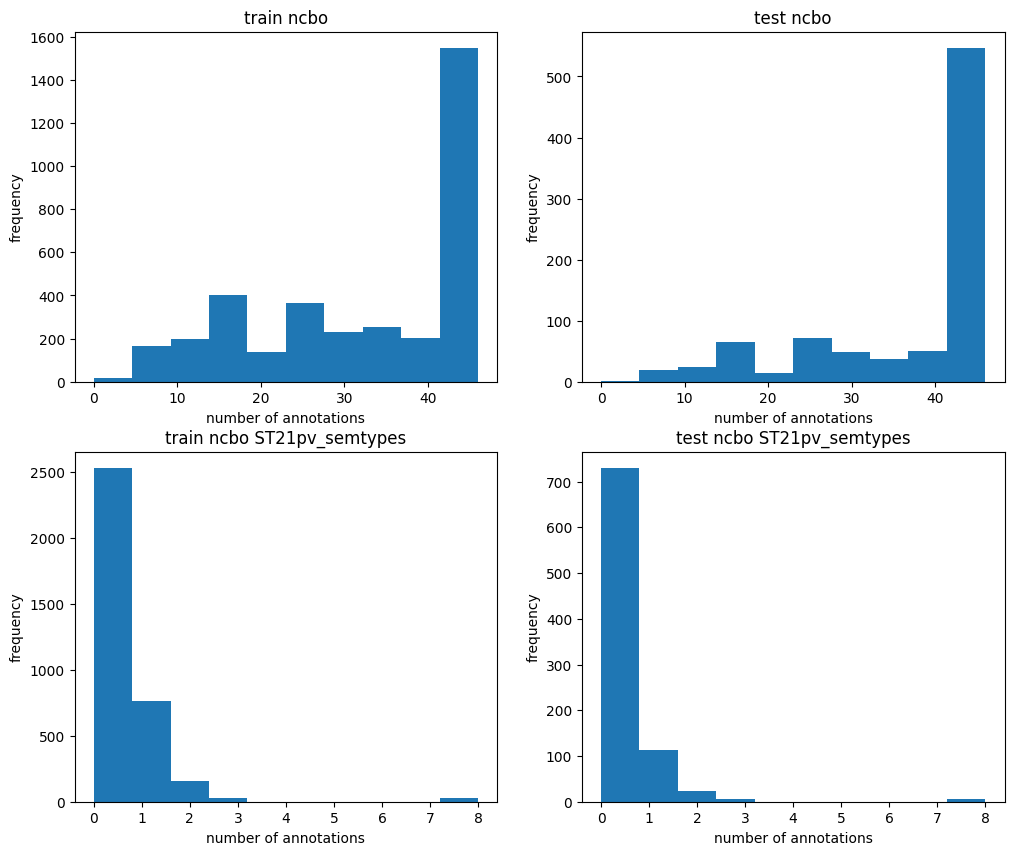

In [222]:
fig, axes = plt.subplots(2,2, figsize=(12, 10))


ax = axes[0,0]
plot_hist(axes[0,0], train_number_of_ncbo_annotations, "number of annotations", "frequency", "train ncbo")
plot_hist(axes[0,1], test_number_of_ncbo_annotations, "number of annotations", "frequency", "test ncbo")
plot_hist(axes[1,0], train_number_of_ncbo_annotations_ST21pv_semtypes, "number of annotations", "frequency", "train ncbo ST21pv_semtypes")
plot_hist(axes[1,1], test_number_of_ncbo_annotations_ST21pv_semtypes, "number of annotations", "frequency", "test ncbo ST21pv_semtypes")
